In [58]:
import pandas
import pm4py
from pm4py.objects.log.obj import EventLog, Trace
from nltk.cluster import KMeansClusterer
import nltk 
from sklearn import cluster
from sklearn import metrics
import time
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [59]:
event_log = pm4py.read_xes('logs/sintetico_completo.xes', sep=',')
#lawsuit_id,date,movement,order,status,area,subject_matter,control,digital,class,distribution_date,court_department,claim_amount,judge
event_log = pm4py.format_dataframe(event_log, case_id='case:concept:name', activity_key='Activity', timestamp_key='time:timestamp')
event_log['time:timestamp']=pd.to_datetime(event_log['time:timestamp'], utc=True) # format the timestamp column

parsing log, completed traces ::   0%|          | 0/4501 [00:00<?, ?it/s]

In [60]:
event_log.head(200)

,lifecycle:transition,org:resource,time:timestamp,Activity,Resource,elementId,resourceId,case:concept:name,case:variant,case:variant-index,case:creator,case:processId,concept:name,@@index,@@case_index
0,complete,,2024-12-05 09:00:00+00:00,start,,id84b101e2-1693-4745-9c56-73bd9931c244,NaN,0,Variant 2769,2769,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,start,0,0
1,complete,Default Resource-000001,2024-12-05 09:00:00+00:00,Declarada incompetência,Default Resource-000001,id0a8b72b5-f7ca-422c-ae9c-69ad479476a7,QBP_DEFAULT_RESOURCE,0,Variant 2769,2769,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Declarada incompetência,1,0
2,complete,Default Resource-000001,2024-12-05 09:00:00+00:00,Certidão de Publicação Expedida,Default Resource-000001,idfc5ac571-30b9-473a-a330-dcc895e64a7d,QBP_DEFAULT_RESOURCE,0,Variant 2769,2769,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Certidão de Publicação Expedida,2,0
3,complete,Default Resource-000001,2024-12-05 09:00:00+00:00,Recebida a Petição Inicial - Citação Por Cart...,Default Resource-000001,idd3e81bbb-564a-4e7c-bd1b-9983bb0bc7fc,QBP_DEFAULT_RESOURCE,0,Variant 2769,2769,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Recebida a Petição Inicial - Citação Por Cart...,3,0
4,complete,Default Resource-000001,2024-12-05 09:00:00+00:00,Notificação Juntada,Default Resource-000001,iddc40f639-0cf3-416e-a3f5-9176838abe24,QBP_DEFAULT_RESOURCE,0,Variant 2769,2769,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Notificação Juntada,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,complete,Default Resource-000001,2024-12-06 13:04:38.282000+00:00,Guia Juntada,Default Resource-000001,ida9875f41-001b-4d43-915f-369de40ed6ac,QBP_DEFAULT_RESOURCE,1001,Variant 657,657,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Guia Juntada,195,5
196,complete,Default Resource-000001,2024-12-06 13:04:38.282000+00:00,Guia Juntada,Default Resource-000001,ida9875f41-001b-4d43-915f-369de40ed6ac,QBP_DEFAULT_RESOURCE,1001,Variant 657,657,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Guia Juntada,196,5
197,complete,Default Resource-000001,2024-12-06 13:04:38.282000+00:00,Remetidos os Autos para o Tribunal de Justiça/...,Default Resource-000001,idd53bfe24-6986-494e-af4b-3353df14f8c3,QBP_DEFAULT_RESOURCE,1001,Variant 657,657,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Remetidos os Autos para o Tribunal de Justiça/...,197,5
198,complete,Default Resource-000001,2024-12-06 13:04:38.282000+00:00,Processo Suspenso ou Sobrestado por Decisão Ju...,Default Resource-000001,ide4b368f8-3c75-4732-984f-515bafa38706,QBP_DEFAULT_RESOURCE,1001,Variant 657,657,Fluxicon Disco,idac924125-3df7-442c-a8f8-5a8901b257ca,Processo Suspenso ou Sobrestado por Decisão Ju...,198,5


In [61]:
def retrieve_traces(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(["".join(x) for x in events])
        ids.append(id)

    return ids, traces

def run_doc2vec_from_ft(vector_size, log):
    ids, traces = retrieve_traces(log)
    start_time = time.time()
    tagged_traces = [TaggedDocument(words=act, tags=[str(i)]) for i, act in enumerate(traces)]
  
    # build the model
    model = Doc2Vec(tagged_traces,dm = 0, alpha=0.025, vector_size=vector_size, window=5, min_alpha=0.001, min_count=2, epochs=10)
    model.build_vocab(tagged_traces)
    model.train(tagged_traces, total_examples=model.corpus_count, epochs=model.epochs)


    #model.save('output/'+folderName+'T2VVS'+str(vectorsize) +'.model')
    #model.save_word2vec_format('output/'+folderName+ 'T2VVS'+str(vectorsize) + '.word2vec')

    vectors = [model.infer_vector(trace) for trace in traces]
    
    end_time = time.time() - start_time
    print(f"\nDoc2vec took {round(end_time, 2)} seconds")

    # saving
    encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(vector_size)])
    encoded_df.insert(2, "case", ids)
    return encoded_df, traces


def create_cluster_kmeans(event_log, traces, encoding, num_clusters):
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(encoding[["0", "1"]])
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    pca = PCA(n_components=2).fit(encoding[["0", "1"]])
    datapoint = pca.transform(encoding[["0", "1"]])
    print(datapoint)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure
    label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#800d00", "#ff2d00", "#ff7100", "#cdff00","#00b9ff", "#ff00f4"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='D', s=200, c='#000000')
    plt.show()

    encoding.insert(3, "d0", datapoint[:, 0])
    encoding.insert(4, "d2", datapoint[:, 1])

    silhouette_score = metrics.silhouette_score(encoding[["0", "1"]], labels)

    print ("[KM]Num_clusters: ")
    print (num_clusters)
    print ("[KM]Silhouette_score: ")
    print (silhouette_score)

    already_seen = {}
    cluster_list = []

    #for i in range(len(traces)):
    #    if not labels[i] in already_seen:
    #        already_seen[labels[i]] = len(list(already_seen.keys()))
    #        cluster_list.append([])
    #    trace = traces[i]
    #    cluster_list[already_seen[labels[i]]].append(trace)
    encoding.insert(5, "traces", traces)
    return encoding, centroidpoint
    



Doc2vec took 1.91 seconds
[[-0.00286974  0.05196494]
 [ 0.0436122   0.3759389 ]
 [-0.08933885  0.23302433]
 ...
 [ 0.01648721  0.1843245 ]
 [-0.00744143  0.22559929]
 [-0.40262407 -0.10439277]]


/Users/cadu/Documents/desenvolvimento/workspace/ml/my_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


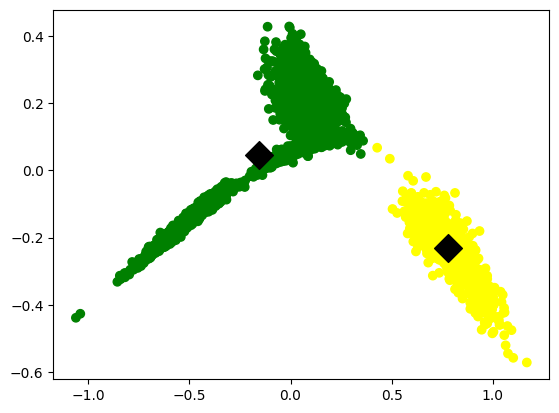

[KM]Num_clusters: 
2
[KM]Silhouette_score: 
0.6388616


In [62]:
vector_size = 2
num_clusters = 2
encoding1, traces = run_doc2vec_from_ft(vector_size, event_log)
encoding1
encoding1, centroidpoint = create_cluster_kmeans(event_log, traces, encoding1, num_clusters)

In [63]:
from scipy.cluster.vq import vq
closest, distances = vq(centroidpoint, encoding1[["d0", "d2"]])

In [64]:
closest

array([1977, 1064], dtype=int32)

In [66]:
print(encoding1.iloc[1977:1978])
print(encoding1.iloc[1064:1065])

             0         1  case        d0        d2  \
1977 -0.550683  1.046376  2778  0.783276 -0.234066   

                                                 traces  
1977  [Data da Publicação SIDAP, start, end, Carga à...  
             0         1  case        d0      d2  \
1064 -0.602357  0.098901  1956 -0.129073  0.0267   

                                                 traces  
1064  [Conclusos para Decisão, AR Negativo Juntado -...  
